# Chapter 6 Learning Best Practices for Model Evaluation and Hyperparameter Tuning

In [1]:
from IPython.display import Image
%matplotlib inline

In [2]:
# Added version check for recent scikit-learn 0.18 checks
from distutils.version import LooseVersion as Version
from sklearn import __version__ as sklearn_version

## Streamlining workflows with pipelines

### Loading the Breast Cancer Wisconsin dataset

In [3]:
import pandas as pd
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data',header=None)

from sklearn.preprocessing import LabelEncoder
X = df.loc[:,2:].values
y = df.loc[:,1].values
le = LabelEncoder()
y=le.fit_transform(y)

In [4]:
le.transform(['M','B'])

array([1, 0], dtype=int64)

In [5]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

C:\Users\charlie_chiu\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Combining transformers and estimators in a pipeline

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
pipe_lr = Pipeline([('scl', StandardScaler()),
                   ('pca', PCA(n_components=2)),
                   ('clf', LogisticRegression(random_state=1))])
pipe_lr.fit(X_train, y_train)
print('Train Accuracy: %.3f' % pipe_lr.score(X_train, y_train))
print('Test Accuracy: %.3f' % pipe_lr.score(X_test, y_test))

Train Accuracy: 0.954
Test Accuracy: 0.947


## Using k-fold cross-validation to assess model preformance

### The stratified k-fold

In [7]:
import numpy as np
from sklearn.cross_validation import StratifiedKFold
kfold = StratifiedKFold(y=y_train,
                       n_folds=10,
                       random_state=1)
scores=[]
for k, (train, test) in enumerate(kfold):
    pipe_lr.fit(X_train[train], y_train[train])
    score = pipe_lr.score(X_train[test], y_train[test])
    scores.append(score)
    print('Fold: %s, Class dist.: %s, ACC: %.3f' % (k+1, np.bincount(y_train[train]), score))

Fold: 1, Class dist.: [256 153], ACC: 0.891
Fold: 2, Class dist.: [256 153], ACC: 0.978
Fold: 3, Class dist.: [256 153], ACC: 0.978
Fold: 4, Class dist.: [256 153], ACC: 0.913
Fold: 5, Class dist.: [256 153], ACC: 0.935
Fold: 6, Class dist.: [257 153], ACC: 0.978
Fold: 7, Class dist.: [257 153], ACC: 0.933
Fold: 8, Class dist.: [257 153], ACC: 0.956
Fold: 9, Class dist.: [257 153], ACC: 0.978
Fold: 10, Class dist.: [257 153], ACC: 0.956


In [8]:
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy: 0.950 +/- 0.029


### Alternative: Using `cross_val_score` to calculate the score

In [9]:
from sklearn.cross_validation import cross_val_score
scores = cross_val_score(estimator = pipe_lr,
                        X=X_train,
                        y=y_train,
                        cv=10,
                        n_jobs=1)
print('CV accuracy scores: %s' % scores)

CV accuracy scores: [ 0.89130435  0.97826087  0.97826087  0.91304348  0.93478261  0.97777778
  0.93333333  0.95555556  0.97777778  0.95555556]


In [10]:
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy: 0.950 +/- 0.029


## Debugging algorithms with learning and validation curves

### Diagnosing bias and variance problems with learning curves

C:\Users\charlie_chiu\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\learning_curve.py:23: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)


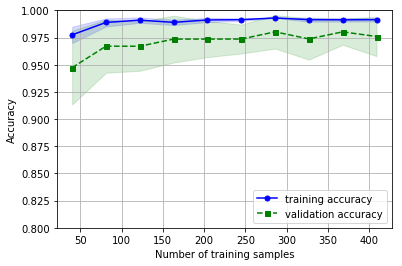

In [11]:
import matplotlib.pyplot as plt
from sklearn.learning_curve import learning_curve
pipe_lr = Pipeline([('scl', StandardScaler()),
                   ('clf', LogisticRegression(penalty='l2', random_state=0)),])
train_sizes, train_scores, test_scores = learning_curve(estimator=pipe_lr,
                                                       X=X_train,
                                                       y=y_train,
                                                       train_sizes=np.linspace(0.1,1.0,10),
                                                       cv=10,
                                                       n_jobs=1)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='training accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='validation accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.0])
plt.show()

### Addressing overfitting and underfitting with validation curves

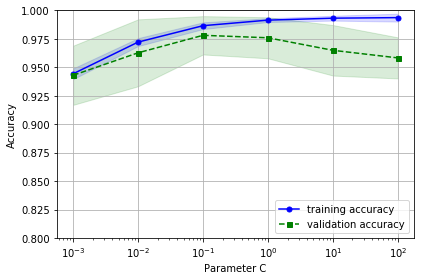

In [12]:
if Version(sklearn_version) < '0.18':
    from sklearn.learning_curve import validation_curve
else:
    from sklearn.model_selection import validation_curve



param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
train_scores, test_scores = validation_curve(
                estimator=pipe_lr, 
                X=X_train, 
                y=y_train, 
                param_name='clf__C', 
                param_range=param_range,
                cv=10)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(param_range, train_mean, 
         color='blue', marker='o', 
         markersize=5, label='training accuracy')

plt.fill_between(param_range, train_mean + train_std,
                 train_mean - train_std, alpha=0.15,
                 color='blue')

plt.plot(param_range, test_mean, 
         color='green', linestyle='--', 
         marker='s', markersize=5, 
         label='validation accuracy')

plt.fill_between(param_range, 
                 test_mean + test_std,
                 test_mean - test_std, 
                 alpha=0.15, color='green')

plt.grid()
plt.xscale('log')
plt.legend(loc='lower right')
plt.xlabel('Parameter C')
plt.ylabel('Accuracy')
plt.ylim([0.8, 1.0])
plt.tight_layout()
# plt.savefig('./figures/validation_curve.png', dpi=300)
plt.show()

## Fine-tuning machine learning model via grid search

### Tuning hyperparameters via grid search

In [13]:
from sklearn.grid_search import GridSearchCV
from sklearn.svm import SVC
pipe_svc = Pipeline([('scl', StandardScaler()),
                    ('clf', SVC(random_state=1))])
param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
param_grid = [{'clf__C': param_range,
               'clf__kernel': ['linear']},
              {'clf__C': param_range,
               'clf__gamma': param_range,
               'clf__kernel': ['rbf']}]
gs = GridSearchCV(estimator = pipe_svc,
                 param_grid = param_grid,
                 scoring = 'accuracy',
                 cv = 10,
                 n_jobs = -1)
gs = gs.fit(X_train, y_train)
print(gs.best_score_)

C:\Users\charlie_chiu\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


0.978021978021978


In [14]:
print(gs.best_params_)

{'clf__C': 0.1, 'clf__kernel': 'linear'}


In [16]:
print(gs.best_estimator_)

Pipeline(steps=[('scl', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=1, shrinking=True,
  tol=0.001, verbose=False))])


In [15]:
clf = gs.best_estimator_
clf.fit(X_train, y_train)
print('Test Accuracy: %.3f' % clf.score(X_test, y_test))

Test Accuracy: 0.965


### Algorithm selection with nested cross-validation

***A 5x2 nested cross-validation***

In [20]:
gs = GridSearchCV(estimator = pipe_svc,
                 param_grid = param_grid,
                 scoring = 'accuracy',
                 cv = 2,
                 n_jobs = -1)
scores = cross_val_score(gs, X_train, y_train, scoring = 'accuracy', cv = 5)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy: 0.965 +/- 0.025


In [19]:
from sklearn.tree import DecisionTreeClassifier

gs = GridSearchCV(estimator=DecisionTreeClassifier(random_state=0),
                  param_grid=[{'max_depth': [1, 2, 3, 4, 5, 6, 7, None]}],
                  scoring='accuracy',
                  cv=2)
scores = cross_val_score(gs, X_train, y_train, scoring='accuracy', cv=5)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy: 0.921 +/- 0.029


## Looking at different performance evaluation metrics

### Reading a confusion matrix

In [21]:
from sklearn.metrics import confusion_matrix
pipe_svc.fit(X_train, y_train)
y_pred = pipe_svc.predict(X_test)
confmat = confusion_matrix(y_true = y_test, y_pred = y_pred)
print(confmat)

[[71  1]
 [ 2 40]]


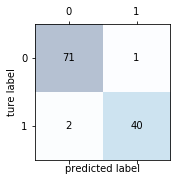

In [27]:
fig, ax = plt.subplots(figsize = (2.5, 2.5))
ax.matshow(confmat, cmap = plt.cm.Blues, alpha = 0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i,
               s=confmat[i,j],
               va='center', ha='center')
plt.xlabel('predicted label')
plt.ylabel('ture label')
plt.show()

### Optimizing the precision and recall of a classification model

In [28]:
from sklearn.metrics import precision_score, recall_score, f1_score

print('Precision: %.3f' % precision_score(y_true=y_test, y_pred=y_pred))
print('Recall: %.3f' % recall_score(y_true=y_test, y_pred=y_pred))
print('F1: %.3f' % f1_score(y_true=y_test, y_pred=y_pred))

Precision: 0.976
Recall: 0.952
F1: 0.964


In [29]:
from sklearn.metrics import make_scorer

scorer = make_scorer(f1_score, pos_label=0)

c_gamma_range = [0.01, 0.1, 1.0, 10.0]

param_grid = [{'clf__C': c_gamma_range,
               'clf__kernel': ['linear']},
              {'clf__C': c_gamma_range,
               'clf__gamma': c_gamma_range,
               'clf__kernel': ['rbf']}]

gs = GridSearchCV(estimator=pipe_svc,
                  param_grid=param_grid,
                  scoring=scorer,
                  cv=10,
                  n_jobs=-1)
gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.9827986682076318
{'clf__C': 0.1, 'clf__kernel': 'linear'}


### Plotting a receiver operating characteristic (ROC curve)

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 152 157]
[150 151 153 154 155 156 158 159 160 161 162 163 164 165 166 167 168 169
 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187
 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205
 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223
 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241
 242 243 244 245 

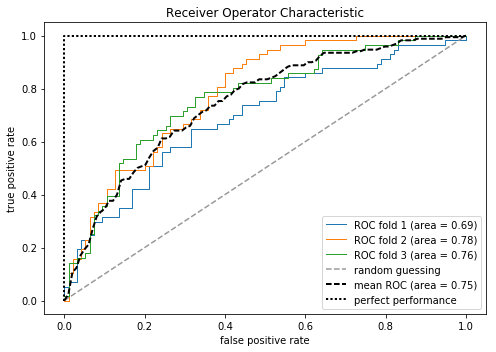

In [64]:
from sklearn.metrics import roc_curve, auc
from scipy import interp

pipe_lr = Pipeline([('scl', StandardScaler()),
                    ('pca', PCA(n_components=2)),
                    ('clf', LogisticRegression(penalty='l2', 
                                               random_state=0, 
                                               C=100.0))])

X_train2 = X_train[:, [4, 14]]


#if Version(sklearn_version) < '0.18':
cv = StratifiedKFold(y_train, 
                     n_folds=3, 
                     random_state=1)
for train_t, test_t in cv:
    print(test_t)
    
#else:
#    cv = list(StratifiedKFold(n_splits=3, 
#                              random_state=1).split(X_train, y_train))

fig = plt.figure(figsize=(7, 5))

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

for i, (train, test) in enumerate(cv):
    probas = pipe_lr.fit(X_train2[train],
                         y_train[train]).predict_proba(X_train2[test])

    fpr, tpr, thresholds = roc_curve(y_train[test],
                                     probas[:, 1],
                                     pos_label=1)
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr,
             tpr,
             lw=1,
             label='ROC fold %d (area = %0.2f)'
                   % (i+1, roc_auc))

plt.plot([0, 1],
         [0, 1],
         linestyle='--',
         color=(0.6, 0.6, 0.6),
         label='random guessing')

mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--',
         label='mean ROC (area = %0.2f)' % mean_auc, lw=2)
plt.plot([0, 0, 1],
         [0, 1, 1],
         lw=2,
         linestyle=':',
         color='black',
         label='perfect performance')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title('Receiver Operator Characteristic')
plt.legend(loc="lower right")

plt.tight_layout()
# plt.savefig('./figures/roc.png', dpi=300)
plt.show()

In [35]:
pipe_lr = pipe_lr.fit(X_train2, y_train)
y_pred2 = pipe_lr.predict(X_test[:, [4, 14]])

In [36]:
from sklearn.metrics import roc_auc_score, accuracy_score
print('ROC AUC: %.3f' % roc_auc_score(y_true=y_test, y_score=y_pred2))
print('Accuracy: %.3f' % accuracy_score(y_true=y_test, y_pred=y_pred2))

ROC AUC: 0.662
Accuracy: 0.711


### The scoring metrics for multiclass classification

In [37]:
pre_scorer = make_scorer(score_func=precision_score, 
                         pos_label=1, 
                         greater_is_better=True, 
                         average='micro')